In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 22 14:56:44 2020
@author: aborst
"""

import numpy as np
import matplotlib.pyplot as plt
import blindschleiche_py3 as bs
from scipy import ndimage

from scipy import stats
from scipy.signal import savgol_filter
import octopus as oct

In [2]:
mylabelsize = 10
mylegendsize = 10

maxtime = 1000
deltat = 10.0
myt = np.arange(maxtime) * deltat / maxtime

tf = np.zeros(1000)
tf[100:400] = 1.0
tf[600:900] = -1.0
 
noisefac = 0.0

T4d = np.zeros((30, 28, maxtime))
T4c = np.zeros((30, 28, maxtime))
T5d = np.zeros((30, 28, maxtime))
T5c = np.zeros((30, 28, maxtime))

T4T5d = np.zeros((6, 6, maxtime))
T4T5c = np.zeros((6, 6, maxtime))

LPi43 = np.zeros((6, 6, maxtime))
LPi34 = np.zeros((6, 6, maxtime))

T4T5d_mean = np.zeros(maxtime)
T4T5c_mean = np.zeros(maxtime)
LPi43_mean = np.zeros(maxtime)
LPi34_mean = np.zeros(maxtime)

VS = np.zeros(maxtime)
Vx = np.zeros(maxtime)

VSg_total = np.zeros(maxtime)
VSx_total = np.zeros(maxtime)

Vm = np.zeros((6, maxtime))
Vinp = np.zeros((6, maxtime))

In [3]:
# L = LPi, T = T4T5, V = Vertical Cell

defaultLTgain = 0.5 # a
defaultTLgain = 1.0 # b
defaultLLgain = 1.0 # c
defaultTVgain = 1.0 # d
defaultLVgain = 1.0 # e

LVgain = defaultLVgain
LLgain = defaultLLgain
LTgain = defaultLTgain
TVgain = defaultTVgain
TLgain = defaultTLgain

connM = np.zeros((6, 6))

thrld = 0.0

tauT = 20.0
tauLPi = 20.0
tauVS = 20.0

tau = np.array([tauT, tauT, tauLPi, tauLPi, tauVS, tauVS])

In [4]:
# ------ network calculations ------------------------

def set_connM():
    
    global connM
    
    connM[0,:] = [0, 0, 0, -LTgain, 0, 0]
    connM[1,:] = [0, 0, -LTgain, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, -LLgain, 0, 0]
    connM[3,:] = [0, TLgain, -LLgain, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5,:] = [0, TVgain, -LVgain, 0, 0, 0]
    
    #print('Circuit reset')
    
    #print(connM)
    
    
def block_feedb():
    
    global connM
    
    connM[0, :] = [0, 0, 0, 0, 0, 0]
    connM[1, :] = [0, 0, 0, 0, 0, 0]
    connM[2, :] = [TLgain, 0, 0, 0, 0, 0]
    connM[3, :] = [0, TLgain, 0, 0, 0, 0]
    connM[4, :] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5, :] = [0, TVgain, -LVgain, 0, 0, 0]
    
    #print('Feedback blocked')
    
    #print(connM)

def block_LPi43():
    
    global connM
    
    connM[:,2] = 0
    
    #print('LPi4-3 blocked')
    
    #print(connM)
    
def block_LPi34():
    
    global connM
    
    connM[:, 3] = 0
    
    #print('LPi3-4 blocked')
    
    #print(connM ) 
    
def block_T4T5c():
    
    global connM
    
    connM[:, 1] = 0
    
    #print('T4T5c blocked')
    
    #print(connM)
    
def reset_gains():
    
    global LVgain, LLgain, LTgain, TVgain, TLgain
    
    LVgain = defaultLVgain
    LLgain = defaultLLgain
    LTgain = defaultLTgain
    TVgain = defaultTVgain
    TLgain = defaultTLgain
    
    set_connM()
    
set_connM()

def small_network():
    
    for t in range(1,maxtime):

        total_input = connM.dot(bs.rect(Vm[:, t - 1], thrld)) + Vinp[:, t-1]
        Vm[:,t] = deltat / tau * (total_input - Vm[:, t-1]) + Vm[:, t-1]
        
    return Vm

def test_small_network():
    
    set_connM()
    
    Vinp[0] = np.zeros(maxtime)
    Vinp[0, 200:800] = 1.0
    Vinp[1] = np.zeros(maxtime)
    Vinp[1, 200:800] = 1.0
    
    Vm=small_network()
    
    plt.plot(Vm[0], label = 'T4T5d')
    plt.plot(Vm[3], label = 'LPi34')
    plt.legend(loc = 1, frameon = False)
    
def calc_HRBL(lp, hp):
    
    noff = 30
    DC = 0.02
    
    A = bs.rect(lp[:, 0:noff-2, :], 0)
    B = bs.rect(hp[:, 1:noff-1, :], 0)
    C = bs.rect(lp[:, 2:noff-0, :], 0)
    
    Txa = bs.rect(A * B / (DC + C), DC)
    
    A = bs.rect(lp[:, 2:noff-0, :], 0)
    B = bs.rect(hp[:, 1:noff-1, :], 0)
    C = bs.rect(lp[:, 0:noff-2, :], 0)
    
    Txb = bs.rect(A * B / (DC + C), DC)
    
    return Txa, Txb


In [5]:
#  ---------------------------- Large Network ---------------------------------

def large_network():
    
    global T4d,T4c,T5d,T5c,T4T5d_mean,T4T5c_mean,LPi43_mean,LPi34_mean,stimulus,VS,Vx,VSg_total,Vxg_total
    
    syn_gain = 1
    
    n = stimulus.shape
    maxtime = n[2]
    noff = 30
        
    lptau = 50.0 / deltat
    hptau = 250.0 / deltat
        
    R16 = bs.rebin(stimulus, noff, noff, maxtime)
     
    interim = bs.highpass(R16, hptau)
    interim = interim + 0.1 * R16
    L1 = bs.rect(interim, 0)
    L2 = bs.rect(-(interim - 0.05), 0)
    
    ONlp = bs.lowpass(R16, lptau)
    ONhp = L1
    OFFlp = bs.lowpass(1.0 - R16, lptau)
    OFFhp = L2

    T4d, T4c = calc_HRBL(ONlp, ONhp)
    T5d, T5c = calc_HRBL(OFFlp, OFFhp)
    
    for i in range(6):
        
        for j in range(6):
            
            Vinp[0]  = np.mean(bs.rect(T4d[i*5:i*5+5,j*5:j*5+5,:],0), axis=(0,1))
            Vinp[0] += np.mean(bs.rect(T5d[i*5:i*5+5,j*5:j*5+5,:],0), axis=(0,1))
            
            Vinp[1]  = np.mean(bs.rect(T4c[i*5:i*5+5,j*5:j*5+5,:],0), axis=(0,1))
            Vinp[1] += np.mean(bs.rect(T5c[i*5:i*5+5,j*5:j*5+5,:],0), axis=(0,1))
            
            Vm = small_network()
            
            T4T5d[i,j] = Vm[0]
            T4T5c[i,j] = Vm[1]
            LPi43[i,j] = Vm[2]
            LPi34[i,j] = Vm[3]
            
    T4T5d_mean = np.mean(T4T5d,axis = (0,1))
    T4T5c_mean = np.mean(T4T5c,axis = (0,1))
    LPi43_mean = np.mean(LPi43,axis = (0,1))
    LPi34_mean = np.mean(LPi34,axis = (0,1))
    
    T4T5d_mean = T4T5d_mean - np.mean(T4T5d_mean[0:250])
    T4T5c_mean = T4T5c_mean - np.mean(T4T5c_mean[0:250])
    LPi43_mean = LPi43_mean - np.mean(LPi43_mean[0:250])
    LPi34_mean = LPi34_mean - np.mean(LPi34_mean[0:250]) 
    
       
    # Calculate conductances of VS inputs
    
    gexcVS = np.mean(bs.rect(T4T5d, thrld), axis = (0,1)) * connM[4,0] * syn_gain
    ginhVS = np.mean(bs.rect(LPi34, thrld), axis = (0,1)) * (-connM[4,3]) * syn_gain
    
    gexcVx = np.mean(bs.rect(T4T5c, thrld), axis = (0,1)) * connM[5,1] * syn_gain
    ginhVx = np.mean(bs.rect(LPi43, thrld), axis = (0,1)) * (-connM[5,2]) * syn_gain
        
    VSg_total = gexcVS + ginhVS + 1.0
    Vxg_total = gexcVx + ginhVx + 1.0
    
    VS = (40.0 * gexcVS - 20.0 * ginhVS) / VSg_total  
    Vx = (40.0 * gexcVx - 20.0 * ginhVx) / Vxg_total
    
    VS = VS - np.mean(VS[0:250])
    Vx = Vx - np.mean(Vx[0:250])
    
    #T4T5d_mean[0:250] = 0
    #T4T5c_mean[0:250] = 0
    #LPi43_mean[0:250] = 0
    #LPi34_mean[0:250] = 0
    #VS[0:250] = 0
    #Vx[0:250] = 0

In [6]:
thrld

0.0

In [7]:
# -----------------------------------------------------------------------------    
# -------------- create visual stimuli, calculate responses -------------------
# -----------------------------------------------------------------------------
# -------------------sine grating directional tuning --------------------------

def calc_singlewave(img_size, new_spat_freq, x, y):
    
    sinewave = np.sin((np.linspace(0,img_size-1,img_size)-x+y)/img_size*2.0*np.pi*new_spat_freq)
    return sinewave
    
def calc_sine(tf, img_rot, spat_freq, contrast):
    
    print()
    print('rot angle =', img_rot)
    
    n = tf.shape
    maxtime = n[0]
    img_size = 180
    movie = np.zeros((img_size,img_size,maxtime))
    img_rot_rad = img_rot / 360.0 * 2 * np.pi
    new_spat_freq = spat_freq * np.cos(img_rot_rad)
    spat_wlength = img_size / spat_freq
    velo = tf * spat_wlength / 100.0
    
    print('Spatial Wavelength =', spat_wlength)
    print('Velocity  (dt=10 msec) =', np.max(np.abs(velo)) * 100, 'deg/s')
    print('Temp Freq (dt=10 msec) =', np.max(np.abs(tf)), 'Hz')
    
    yshift = np.tan(img_rot_rad)
    
    new_velo = velo / np.cos(img_rot_rad)
    
    if img_rot == 0:
        image = np.zeros((img_size, img_size))
        interim = calc_singlewave(img_size, spat_freq, 0, 0)
        for i in range(img_size):
            image[i,0::] = interim 
        for i in range(maxtime):
            movie[:,:,i] = np.roll(image, int(sum(velo[0:i])), axis=1)      
    else:        
        for i in range(maxtime):
                for y in range(img_size):
                    movie[y,:,i] = calc_singlewave(180,new_spat_freq,int(sum(new_velo[0:i])),int(yshift*y))  
                    
    movie = movie * contrast * 0.5 + 0.5
    
    return movie
    
def store_grating_dir_stimuli_on_disc():
    
    tf = np.zeros(maxtime)
    tf[100:maxtime] = 1.0
    
    dirname = 'C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'
    
    for i in range(12):
    
        angle = i * 30
        print(angle,' deg')
        
        stimulus = calc_sine(tf, angle, 6, 1)
        
        fname = 'Grating' + np.str(angle) + 'deg.npy'
        print(fname)
        
        np.save(dirname + fname, stimulus)
    
def calc_dirtuning():
    
    global stimulus
    
    nofconditions = 4
    nofcells = 6
    nofdirs = 12
    
    dirtuning = np.zeros((nofcells, nofconditions, nofdirs))
    
    dirname='C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'
    
    for direction in range(12):
        
        angle = direction * 30
        #print(angle,' deg')
        fname = 'Grating' + np.str(angle) + 'deg.npy'
        stimulus = np.load(dirname + fname)
        
        for condition in range(nofconditions):
            
            reset_gains()
            
            # set condition
            
            if condition == 0: reset_gains()  
            if condition == 1: block_LPi43()
            if condition == 2: block_T4T5c()
            if condition == 3: block_feedb()
        
            large_network()
        
            # assign cells to output array
            
            dirtuning[0,condition,direction] = np.mean(T4T5d_mean[500:maxtime])-np.mean(T4T5d_mean[50:100])
            dirtuning[1,condition,direction] = np.mean(T4T5c_mean[500:maxtime])-np.mean(T4T5c_mean[50:100])
            dirtuning[2,condition,direction] = np.mean(LPi43_mean[500:maxtime])-np.mean(LPi43_mean[50:100])
            dirtuning[3,condition,direction] = np.mean(LPi34_mean[500:maxtime])-np.mean(LPi34_mean[50:100])
            dirtuning[4,condition,direction] = np.mean(VS[500:maxtime])-np.mean(VS[50:100])
            dirtuning[5,condition,direction] = np.mean(Vx[500:maxtime])-np.mean(Vx[50:100])
        
    return dirtuning

In [8]:
#  -------------- transparent motion ------------------------------------------
    
def calc_TM_stimulus(maxtime, velo, index):

    nofdots = 200 # total number of dots in whole movie
    
    PD = [0.0, 12.5, 25.0, 37.5, 50.0, 50.0, 50.0, 50.0, 50.0, 100.0, 0.0]
    ND = [50.0, 50.0, 50.0, 50.0, 50.0, 37.5, 25.0, 12.5, 0.0, 0.0, 100.0]
    ST = [50.0, 37.5, 25.0, 12.5, 0.0, 12.5, 25.0, 37.5, 50.0, 0.00, 0.00]
        
    nofPD_dots = int(PD[index] * 0.01 * nofdots)
    nofND_dots = int(ND[index] * 0.01 * nofdots)
    nofST_dots = int(ST[index] * 0.01 * nofdots)
    
    print( 'nof dots: ', nofdots)
    print( 'nof PD d: ', nofPD_dots)
    print( 'nof ND d: ', nofND_dots)
    print( 'nof ST d: ', nofST_dots)
    
    movie = np.zeros((200,200,maxtime))
    
    # avoid placing dots on edges by limiting xpos and ypos to bewteen 10 and 190    
    
    PDxpos = np.random.randint(10,190, size=nofPD_dots)
    PDypos = np.random.randint(10,190, size=nofPD_dots)
    
    NDxpos = np.random.randint(10,190, size=nofND_dots)
    NDypos = np.random.randint(10,190, size=nofND_dots)
     
    STxpos = np.random.randint(10,190, size=nofST_dots)
    STypos = np.random.randint(10,190, size=nofST_dots)
    
    # calc individual patch
    
    patch = bs.Gauss2D(5,20)
    patch = patch / np.max(patch)
    
    # set up frames
    
    PDframe = np.zeros((200,200))
    NDframe = np.zeros((200,200))
    STframe = np.zeros((200,200))
    
    # put patches on frames
    
    if nofPD_dots > 0:
    
        interim = np.zeros((200, 200, nofPD_dots))
        for i in range(nofPD_dots):
            interim[PDxpos[i]-10:PDxpos[i]+11,PDypos[i]-10:PDypos[i]+11,i] = patch
        PDframe = interim.max(2)
        
    if nofND_dots > 0:
    
        interim = np.zeros((200,200,nofND_dots))
        for i in range(nofND_dots):
            interim[NDxpos[i]-10:NDxpos[i]+11,NDypos[i]-10:NDypos[i]+11,i] = patch
        if nofND_dots>0:
            NDframe = interim.max(2)
            
    if nofST_dots > 0:

        interim = np.zeros((200,200,nofST_dots))
        for i in range(nofST_dots):
            interim[STxpos[i]-10:STxpos[i]+11,STypos[i]-10:STypos[i]+11,i] = patch
        if nofST_dots>0:
            STframe = interim.max(2)
    
    # calculate movie
    
    for i in range(maxtime):
        
        f1 = np.roll(PDframe, int(velo*i))
        f2 = np.roll(NDframe, -int(velo*i))
        f3 = STframe
        z = np.stack((f1,f2,f3))
        movie[:,:,i] = z.max(0)
        
    for i in range(250):   
        movie[:,:,i] = movie[:,:,250]
        
    for i in range(250):   
        movie[:,:,i+750] = movie[:,:,750]
        
    return movie
    
def store_TM_stimuli_on_disk():
    
    dirname='C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'

    for i in range(9):
        
        fname = 'TPnoise' + np.str(i) + '.npy'
        stim = calc_TM_stimulus(1000, 1, i)
        np.save(dirname + fname, stim)

def calc_TM_response(nofreps = 1, switch = 2):
    
    # if switch=1: stimulus is read from file on disk
    # if switch=2: stimulus is calculated each time
    
    global LVgain, LLgain, LTgain, TVgain, TLgain, VS, stimulus
    
    nofcells = 6
    nofconditions = 4
    nofstim = 3 # PD, ND, TM
    
    dirname = 'C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'
    fname = ['TPnoise0.npy', 'TPnoise8.npy', 'TPnoise4.npy']
    stim_seq = [0, 8, 4]

    TM_response = np.zeros((nofcells, nofconditions, nofstim, maxtime))
    
    for n in range(nofreps):

        for stim in range(3):

            if switch == 1:
                stimulus = np.load(dirname + fname[stim])
                print('filename=', fname[stim])
            if switch == 2:
                stimulus = calc_TM_stimulus(maxtime, 1, stim_seq[stim])
                print('calculated new TM stimulus')
                
            stimulus = stimulus[0:180,0:180]
            
            for condition in range(nofconditions):
            
                reset_gains()
                
                # set condition
                
                if condition == 0: reset_gains()  
                if condition == 1: block_LPi43()
                if condition == 2: block_T4T5c()
                if condition == 3: block_feedb()
            
                large_network()

                TM_response[0,condition,stim] += T4T5d_mean - np.mean(T4T5d_mean[0:100])
                TM_response[1,condition,stim] += T4T5c_mean - np.mean(T4T5c_mean[0:100])
                TM_response[2,condition,stim] += LPi43_mean - np.mean(LPi43_mean[0:100])
                TM_response[3,condition,stim] += LPi34_mean - np.mean(LPi34_mean[0:100])
                TM_response[4,condition,stim] += VS - np.mean(VS[0:100])
                TM_response[5,condition,stim] += Vx - np.mean(Vx[0:100])
            
    TM_response = TM_response / (1.0 * nofreps)
    
    return TM_response

In [9]:
#  -------------- VS conductance change ---------------------------------------

def calc_split_motion_stimulus():
    
    PD_motion = calc_TM_stimulus(1000, 1, 9)
    ND_motion = calc_TM_stimulus(1000, 1, 10)
    split_motion = 1.0 * PD_motion
    split_motion[100:200] = ND_motion[100:200]
    
    return split_motion

def store_split_motion_to_disk():
    
    dirname = 'C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'
    
    stim = calc_split_motion_stimulus()
    np.save(dirname + 'split_motion.npy', stim)

def calc_VS_conductance(condition = 3, switch = 2):
    
    global stimulus
    
    # if switch=1: stimulus is read from file on disk
    # if switch=2: stimulus is calculated each time
    
    VS_cntrl = np.zeros((4, maxtime))
    VS_block = np.zeros((4, maxtime))
    g_cntrl = np.zeros((4, maxtime))
    g_block = np.zeros((4, maxtime))
    
    dirname = 'C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel'
    
    fname = ['TPnoise8.npy','TPnoise0.npy','TPnoise4.npy','split_motion.npy']
    stim_seq = [8, 0, 4]
    
    for i in range(4):
        
        if switch == 1:
            stimulus = np.load(dirname + fname[i])
            print(fname[i])
        if switch == 2:
            if i < 3: stimulus = calc_TM_stimulus(maxtime, 1, stim_seq[i])
            if i > 2: stimulus = calc_split_motion_stimulus()
            print('calculated new TM stimulus') 
            
        stimulus = stimulus[10:190, 10:190]
        
        reset_gains()
        
        large_network()
    
        VS_cntrl[i] = 1.0 * VS
        g_cntrl[i] = 1.0 * VSg_total #/np.mean(VSg_total[1:100])
                
        # set condition
        
        if condition == 0: reset_gains()  
        if condition == 1: block_LPi43()
        if condition == 2: block_T4T5c()
        if condition == 3: block_feedb()
        
        large_network()
        
        VS_block[i] = 1.0 * VS
        g_block[i] = 1.0 * VSg_total
        
    return VS_cntrl, VS_block, g_cntrl, g_block
        

In [10]:
# ----------------------------------------------------------------------------
                
def calc_all():
    
    dirtuning = calc_dirtuning()
    TM_response = calc_TM_response()
    VS_cntrl, VS_block, g_cntrl, g_block = calc_VS_conductance()
    
    return dirtuning, TM_response, VS_cntrl, VS_block, g_cntrl, g_block

In [11]:
dirtuning = calc_dirtuning()

In [12]:
#TM_response = calc_TM_response()

In [13]:
#VS_cntrl, VS_block, g_cntrl, g_block = calc_VS_conductance()

In [14]:
#------------------------------------------------------------------------------    
# ----------------------- Plotting --------------------------------------------
#------------------------------------------------------------------------------

plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
mylabel = ['T4d', 'T4c', 'LPi4-3', 'LPi3-4', 'VS', 'Vx']
block_condition = np.array(['Control', 'LPi4-3 block', 'T4T5c block', 'No Feedback'])


In [15]:
# ----------------- Just for me, no figure in paper --------------------------------

def plot_network(condition):
    
    myt = np.arange(maxtime) * 0.01
    cell_color = ['red','purple','orange','blue','magenta','green']
    cell_type = ['T4T5c','T4T5d','LPi34','LPi43','Vx','VS']
    frame_pos = [1,2,5,6]
    mylw = 2
    
    for j in range(2):
    
        for i in range(4):
            
            if i==0: data = np.mean(T4T5c[j*3:j*3+3],axis=(0,1))
            if i==1: data = np.mean(T4T5d[j*3:j*3+3],axis=(0,1))
            if i==2: data = np.mean(LPi34[j*3:j*3+3],axis=(0,1))
            if i==3: data = np.mean(LPi43[j*3:j*3+3],axis=(0,1))

            if condition==1: 
                mycolor='black'
                mylabel='fb block'
            if condition==2: 
                mycolor=cell_color[i]
                mylabel='control'
            
            ylow = -1.0
            yhigh = 1.5
        
            plt.subplot(3,4,j*2+frame_pos[i])
            
            plt.plot(myt,data,color=mycolor,linewidth=mylw,label=mylabel)
            plt.yticks(np.arange(3)-1,np.arange(3)-1)
            plt.xticks(np.arange(3)*5,'')
            plt.title(cell_type[i])
            plt.ylim(ylow,yhigh)
            plt.xlim(0,10)
            
    for j in range(2):
        
        if j==0: data=Vx
        if j==1: data=VS
        
        if condition==1: 
            mycolor='black'
            mylabel='fb block'
        if condition==2: 
            mycolor=cell_color[4+j]
            mylabel='control'
            
        ylow = -4
        yhigh = 8
    
        plt.subplot(3,4,10+j)
        
        plt.plot(myt,data,color=mycolor,linewidth=mylw,label=mylabel)
        plt.title(cell_type[4+j])
        plt.ylim(ylow,yhigh)
        plt.xticks(np.arange(3)*5,np.arange(3)*5)
        plt.xlim(0,10)
        plt.legend(loc=1,frameon=False)
        plt.xlabel('time [s]')
        

def compare_network():
    
    global stimulus
    
    stimulus = stimulus[10:190,10:190]
    
    plt.figure(figsize = (10,6))
    
    block_feedb()
    large_network()
    plot_network(1)
    
    reset_gains()
    large_network()
    plot_network(2)
    

In [25]:
# ---------- Figure 7A -------------------------------------------------------------
    
def plot_dirtuning(input_tuning, cell_color, location):
    
    dirtuning = 1.0 * input_tuning
    
    mydirtuning = np.zeros((4,13))
    
    mylw = 2
    
    for i in range(4):
        dirtuning[i] = dirtuning[i] / np.max(input_tuning[0])
        dirtuning[i] = np.roll(dirtuning[i], -3)
        mydirtuning[i, 0:12] = dirtuning[i]
        mydirtuning[i, 12] = dirtuning[i, 0]
    
     # control

    plt.plot(mydirtuning[0], linewidth = mylw, color = '0.4', label = 'Control', zorder=0)
    plt.scatter(np.arange(13), mydirtuning[0], color = '0.4', linewidth = 0.5, zorder=0)
    
    # T4/T5c block

    plt.plot(mydirtuning[2], linewidth = mylw, color = cell_color, label = 'T4/T5c block', zorder=1)
    plt.scatter(np.arange(13), mydirtuning[2], color = cell_color, linewidth = 0.5, zorder=1)
    
  
    plt.plot(np.arange(13), np.arange(13) * 0, color = '0.05',linestyle = ':', linewidth = 1)
    
    plt.xticks(np.arange(5) * 3, np.arange(5) * 90)
    plt.xlabel(u'Direction [°]', fontsize = mylabelsize)
    
    plt.yticks(np.arange(5)/2-1, np.arange(5)/2-1)
    
    #t.legend(loc = location, frameon = False, fontsize = mylegendsize)
    
    plt.ylim(-1.1, 1.1)
    plt.xlim(0, 12)

    dirtuning_resp = np.zeros((2,13))
    dirtuning_resp[0] = mydirtuning[0]
    dirtuning_resp[1] = mydirtuning[2]
    
    return dirtuning_resp

    
def plot_Figure7A(dirtuning):
    
    fig = plt.figure(figsize = (11, 2.3))
    plt.subplots_adjust(wspace = 0.35)
    #plt.subplots_adjust(hspace = 0.3)
    
    sequence = [4,3,2,1]
    locseq = [4,3,4,3]
    cell_color = ['C2','C1','C0','C3']
    
    dirtuning_resp = np.zeros((4,2,13))
    
    for i in range(4):
    
        ax = fig.add_subplot(1, 4, i+1)
        dirtuning_resp[i] = plot_dirtuning(dirtuning[sequence[i]], cell_color[i], locseq[i])
        if i == 0:
            plt.ylabel('Response [a.u.]', fontsize = mylabelsize)
        #plt.title(mylabel[sequence[i]], fontsize = 10)

        #xticks = np.array([0,90,180,270,360])
        #ax.set_xticklabels(xticks, size=11)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines['left'].set_position(('outward', 7))
        ax.spines['bottom'].set_position(('outward', 7))
        
    return dirtuning_resp

In [26]:
# ----------------------------- plot 7A,B,C -----------------------------------
    
def plot_Figure7(dirtuning, TM_response, VS_cntrl, VS_block, g_cntrl, g_block):
    
    plot_Figure7A(dirtuning)
    plot_Figure7B(TM_response)
    plot_Figure7C(VS_cntrl, VS_block, g_cntrl, g_block)
        

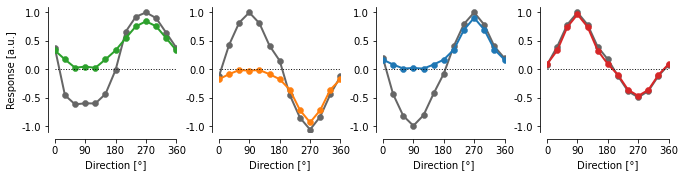

In [27]:
dirtuning_resp = plot_Figure7A(dirtuning)

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7A_Tuning_Curves.pdf', bbox_inches = 'tight', dpi = 600, transparent = True)
plt.show()

In [29]:
# Calculate LDir, MOI, and R_deg for grating tuning curves

dirtuning_resp_12 = dirtuning_resp[:,:,:12]
rot = (np.arange(12) * 30)
rot_rad = np.radians(rot)

LDir_ctrl = np.empty(len(dirtuning_resp_12[:,0,0]))
for i in range(len(dirtuning_resp_12[:,0,0])):
    LDir_ctrl[i] = oct.LDir(rot_rad, dirtuning_resp_12[i,0,:])

LDir_block = np.empty(len(dirtuning_resp_12[:,1,0]))
for i in range(len(dirtuning_resp_12[:,1,0])):
    LDir_block[i] = oct.LDir(rot_rad, dirtuning_resp_12[i,1,:])
    
MOI_ctrl = np.empty(len(dirtuning_resp_12[:,0,0]))
for i in range(len(dirtuning_resp_12[:,0,0])):
    MOI_ctrl[i] = oct.MOI(rot_rad, dirtuning_resp_12[i,0,:])

MOI_block = np.empty(len(dirtuning_resp_12[:,1,0]))
for i in range(len(dirtuning_resp_12[:,1,0])):
    MOI_block[i] = oct.MOI(rot_rad, dirtuning_resp_12[i,1,:])
    
R_deg_ctrl = np.empty(len(dirtuning_resp_12[:,0,0]))
for i in range(len(dirtuning_resp_12[:,0,0])):
    R_deg_ctrl[i] = oct.R_deg(rot_rad, dirtuning_resp_12[i,0,:])

R_deg_block = np.empty(len(dirtuning_resp_12[:,1,0]))
for i in range(len(dirtuning_resp_12[:,1,0])):
    R_deg_block[i] = oct.R_deg(rot_rad, dirtuning_resp_12[i,1,:])

R_magn =5.34270299889142   R_deg = 273.56444333921706
R_indiv_magn = 7.226779124822744
LDir = 0.7392924159727193
R_magn =5.8050559322091875   R_deg = 92.3780432583662
R_indiv_magn = 7.387827274762005
LDir = 0.7857595631722717
R_magn =5.616908677829323   R_deg = 272.4156758598078
R_indiv_magn = 7.152441481276007
LDir = 0.7853134754801597
R_magn =4.034858664500519   R_deg = 91.1851551908574
R_indiv_magn = 5.112986921253916
LDir = 0.7891392500395845
R_magn =2.4352013653821802   R_deg = 269.9948213512603
R_indiv_magn = 4.564198136743679
LDir = 0.5335441828823785
R_magn =2.4075821453252235   R_deg = 90.00019298143208
R_indiv_magn = 3.664670910788769
LDir = 0.6569708996890598
R_magn =2.330425422392065   R_deg = 270.00016686514755
R_indiv_magn = 3.547247036909174
LDir = 0.6569673321716654
R_magn =3.779753839179044   R_deg = 89.98796591477752
R_indiv_magn = 4.6880783135721975
LDir = 0.8062480160018843
D_magn =3.2511565727933256   D_deg = 276.1326100714301
H_magn =2.099871085011256   H_deg = 26

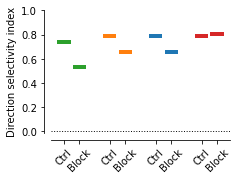

In [32]:
# Make Scatter Plot of LDir

pos = [0, 1, 3, 4, 6, 7, 9, 10]

fig = plt.figure(figsize = (0.4*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6
data = [LDir_ctrl[0], LDir_block[0], LDir_ctrl[1], LDir_block[1], LDir_ctrl[2], LDir_block[2], LDir_ctrl[3], LDir_block[3]]

colors = ['C2', 'C2', 'C1', 'C1', 'C0', 'C0', 'C3', 'C3']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.plot([pos[j]-w/2, pos[j]+w/2],[(data[j]), (data[j])],
            color=colors[j], linestyle='-', linewidth = 4)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('Ctrl','Block', 'Ctrl','Block', 'Ctrl','Block', 'Ctrl','Block'),rotation=45, size=10)
ax.set_ylabel('Direction selectivity index', size=10)
plt.ylim([-0.01,1])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#FigS7_Modelling_LDir.pdf',bbox_inches='tight', dpi=600, transparent=True)

plt.show()

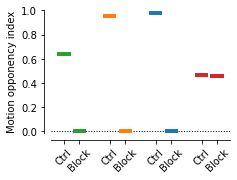

In [34]:
# Make Scatter Plot of MOI

pos = [0, 1, 3, 4, 6, 7, 9, 10]

fig = plt.figure(figsize = (0.4*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6
data = [MOI_ctrl[0], MOI_block[0], MOI_ctrl[1], MOI_block[1], MOI_ctrl[2], MOI_block[2], MOI_ctrl[3], MOI_block[3]]

colors = ['C2', 'C2', 'C1', 'C1', 'C0', 'C0', 'C3', 'C3']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.plot([pos[j]-w/2, pos[j]+w/2],[(data[j]), (data[j])],
            color=colors[j], linestyle='-', linewidth = 4)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('Ctrl','Block', 'Ctrl','Block', 'Ctrl','Block', 'Ctrl','Block'),rotation=45, size=10)
ax.set_ylabel('Motion opponency index', size=10)
plt.ylim([-0.01,1])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#FigS7_Modelling_MOI.pdf',bbox_inches='tight', dpi=600, transparent=True)

plt.show()

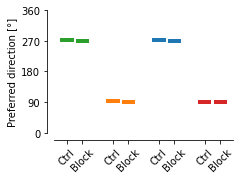

In [37]:
# Make Scatter Plot of R_deg

pos = [0, 1, 3, 4, 6, 7, 9, 10]

fig = plt.figure(figsize = (0.4*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6
data = [R_deg_ctrl[0], R_deg_block[0], R_deg_ctrl[1], R_deg_block[1], R_deg_ctrl[2], R_deg_block[2], R_deg_ctrl[3], R_deg_block[3]]

colors = ['C2', 'C2', 'C1', 'C1', 'C0', 'C0', 'C3', 'C3']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.plot([pos[j]-w/2, pos[j]+w/2],[(data[j]), (data[j])],
            color=colors[j], linestyle='-', linewidth = 4)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('Ctrl','Block', 'Ctrl','Block', 'Ctrl','Block', 'Ctrl','Block'),rotation=45, size=10)
rotations = [0,45,90,135,180,225,270,315,360]
ax.set_yticks((rotations[::2]))
ax.set_yticklabels(rotations[::2])
ax.set_ylabel(u'Preferred direction [°]', size=10)
plt.ylim([-0.01,360])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#FigS7_Modelling_R_deg.pdf',bbox_inches='tight', dpi=600, transparent=True)

plt.show()